# Kalman Filter

We will demonstrate the usefulness of `GT` on the classical [Kalman filter](https://en.wikipedia.org/wiki/Kalman_filter).

## Example: The Kalman Filter

A famous example for timeseries model is the Kalman Filter (and also Smoother). Inference and learning with this model requires exactly the features, that `GT` leverages. Let's see that in a bit more detail. 

The Kalman Filter is a two layered model described by the following equations: 

$$
\color{red}{Z_{t} = A Z_{t-1} + b + \zeta_t} \\
\color{blue}{X_{t} = C Z_t + d + \xi_t},
$$

where $X_t$ are our observations and $Z_t$ latent (unobserved) variables. Furthermore, the noise variables are

$$
\color{red}{\zeta_t \sim N(0,\Sigma_z)}\\
\color{blue}{\xi_t \sim N(0,\Sigma_x)}.
$$

Hence, our model is composed by a $\color{red}{\text{state model}}$ and an $\color{blue}{\text{emission- or observation model}}$, which are two conditional Gaussian densities. Lets create these objects in `GT`.

In [1]:
from gaussian_toolbox import pdf, conditional
from jax import numpy as jnp
from jax import random
from jax import lax

Dz = Dx = 2
A, b = jnp.array([jnp.eye(Dz) - jnp.array([[.01, -.1], [.1, .01]])]), jnp.zeros((1,Dz))
Sigma_z = .001 * jnp.array([jnp.eye(Dz)])
C, d = jnp.array([jnp.eye(Dz)]), jnp.zeros((1,Dz))
Sigma_x = .01 * jnp.array([jnp.eye(Dz)])

state_density = conditional.ConditionalGaussianPDF(M=A, b=b, Sigma=Sigma_z)
observation_density = conditional.ConditionalGaussianPDF(M=C, b=d, Sigma=Sigma_x)

Now we would like to sample data from the generative process, that is depicted by this two objects. For this we need an additional density, the initial density. Then we define a function that does one sample step and iterate that forward.

In [2]:

# Create initial density
mu0, Sigma0 = jnp.zeros((1, Dz)), jnp.array([jnp.eye(Dz)])
p_z0 = pdf.GaussianPDF(Sigma=Sigma0, mu=mu0)


T = 500 # Time steps to sample
### Create PRNGs for sampling
key = random.PRNGKey(0)
subkey, key = random.split(key)
z0 = p_z0.sample(subkey, 1)[0]
range_keys = random.split(key, T+1)
key, range_keys_z = range_keys[0], range_keys[1:]
range_keys = random.split(key, T+1)
key, range_keys_x = range_keys[0], range_keys[1:]
#####################################

def sample_kf(z_prev, keys):
    """Sample one step of the Kalman filter."""
    key_z, key_x = keys
    # Sample state by conditioning the state model on z_{t-1} and then sample z_{t}
    z_cur = state_density(z_prev).sample(key_z, 1)[0]
    # Sample observation by conditioning the observation model on z_{t} and then sample x_{t}
    x_cur = observation_density(z_cur).sample(key_x,1)[0]
    result = z_cur[0], x_cur[0]
    return z_cur, result

# This is just the jax way of writing a for loop
_, result = lax.scan(sample_kf, z0, (range_keys_z, range_keys_x))
z_sample, x_sample = result

Text(0.5, 0, 'Time')

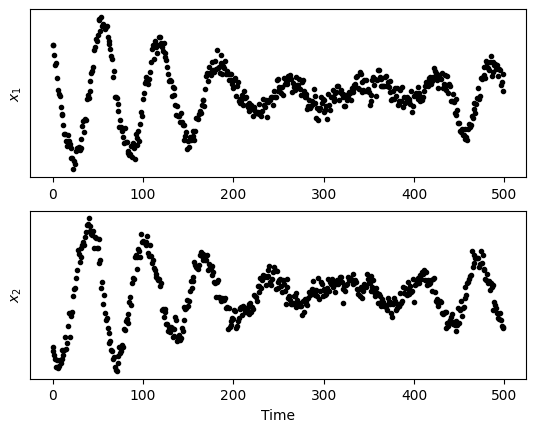

In [3]:
from matplotlib import pyplot as plt
plt.subplot(211)
plt.plot(x_sample[:,0],'k.')
plt.yticks([])
plt.ylabel('$x_1$')
plt.subplot(212)
plt.plot(x_sample[:,1],'k.')
plt.yticks([])
plt.ylabel('$x_2$')
plt.xlabel('Time')

Now having data at hand we would like to estimate the density over latent variables and data again. Hence, we would like to iterate forward the Kalman filter, which consists of two steps.

+ Prediction step:

$$
 {\color{green} p(Z_{t+1}\vert X_{1:t})} = \int {\color{red} p(Z_{t+1}Z_t)}{\color{darkorange} p(Z_t\vert X_{1:t})}{\rm d} Z_t
$$

Has the form of an _affine marginal transformation_ $T_{\rm marg}[p(Y|X),p(X)] = p(Y)$.

+ Filter step:

$$
 {\color{darkorange} p(Z_{t+1}\vert X_{1:t+1})} = \frac{{\color{blue} p(X_{t+1}|Z_{t+1})}{\color{green} p(Z_{t+1}\vert X_{1:t})}}{\int {\color{blue} p(X_{t+1}|Z^\prime_{t+1})}{\color{green} p(Z^\prime_{t+1}\vert X_{1:t})}{\rm d} Z^\prime_{t+1}}
$$

This can be done by an _affine conditional transformation_ and then condition on the observation.

Similar two the sampling procedure, we can define a function that iterates forward these densities. With `GT` this can be done with a only a few lines of code.

In [4]:
def kf_step(previous_filter_density, x_t) -> pdf.GaussianPDF:
    r"""Perform prediction and filter step
    
    .. math::
    
        p(Z_t|X_{1:t-1}) = \int p(Z_t|Z_{t-1})p(Z_{t-1}|X_{1:t-1}) {\rm d}Z_{t-1}
    :param pre_filter_density: Density :math:`p(z_t-1|x_{1:t-1})`
    :type pre_filter_density: pdf.GaussianPDF
    :return: Prediction density :math:`p(z_t|x_{1:t-1})`.
    :rtype: pdf.GaussianPDF
    """
    # p(z_t|x_{1:t-1})
    prediction_density = state_density.affine_marginal_transformation(previous_filter_density)
    p_z_given_x = observation_density.affine_conditional_transformation(prediction_density)
    # Condition on x_t
    cur_filter_density = p_z_given_x.condition_on_x(x_t[None])
    result = (cur_filter_density.Sigma[0], cur_filter_density.mu[0])
    return cur_filter_density, result

_, result = lax.scan(kf_step, p_z0, (x_sample))
Sigma_filter, mu_filter = result
filter_density = pdf.GaussianPDF(Sigma=Sigma_filter, mu=mu_filter)

The Kalman filter provides the filter density over the latent state. If we want the data density we can do that in one line with `GT`.

Text(0.5, 0, 'Time')

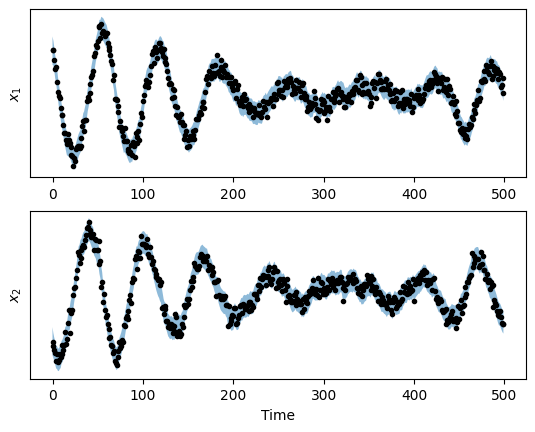

In [5]:
data_density = observation_density.affine_marginal_transformation(filter_density)

std_filter = jnp.sqrt(jnp.diagonal(data_density.Sigma, axis1=-1, axis2=-2))
upper, lower = data_density.mu + 1.98 * std_filter, data_density.mu - 1.98 * std_filter
plt.subplot(211)
plt.plot(x_sample[:,0],'k.')
plt.fill_between(range(T), lower[:,0], upper[:,0], alpha=.5)
plt.yticks([])
plt.ylabel('$x_1$')
plt.subplot(212)
plt.plot(x_sample[:,1],'k.')
plt.fill_between(range(T), lower[:,1], upper[:,1], alpha=.5)
plt.yticks([])
plt.ylabel('$x_2$')
plt.xlabel('Time')

Of course, this is only demonstrating how to perform Kalman-Filter for the known model. But `GT` provides also utilities to e.g. simply calculate the Q-function, which is the objective in the expectation maximization procedure [[Dempster, 1976]](https://www.eng.auburn.edu/~roppeth/courses/00sum13/7970%202013A%20ADvMobRob%20sp13/literature/paper%20W%20refs/dempster%20EM%201977.pdf) to learn the model parameters.